In [1]:
import geatpy as ea
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras import optimizers
from numpy import concatenate
import json
import numpy as np
import geatpy as ea
import pandas as pd
import matplotlib.pyplot as plt  # 用来绘图的库
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import AdaBoostRegressor
from numpy import concatenate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras import optimizers
from sklearn.svm import SVR
from matplotlib import pyplot


import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from numpy import concatenate
import pandas as pd
import matplotlib.pyplot as plt  # 用来绘图的库
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.ensemble import AdaBoostRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras import optimizers
from sklearn.svm import SVR
import numpy as np
import re
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import tensorflow as tf
from tensorflow.compat.v1 import InteractiveSession
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

EA_NAME = ['soea_DE_best_1_bin_templet','soea_DE_best_1_L_templet','soea_DE_rand_1_bin_templet',
           'soea_SGA_templet','soea_EGA_templet','soea_steadyGA_templet','soea_SEGA_templet','soea_studGA_templet']

In [2]:
def calcul_indicator(y,yhat):
    EV = 1 - np.var(y - yhat)/np.var(y)
    MAE = np.sum(np.abs((y - yhat)))/len(y)
    MSE = np.sum(np.multiply((y - yhat),(y - yhat)))/len(y)
    RMSE = sqrt(MSE)
    R_square = 1 - (((y - yhat)**2).sum())/(((y - y.mean())**2).sum())
    return [EV,MAE,MSE,RMSE,R_square]

#克隆选择算法
class ClonalSelectionAlgorithm:
    # 构造函数
    def __init__(self, fitness_func, num_parameters, population_size, clone_factor, mutation_rate, num_generations):
        self.fitness_func = fitness_func
        self.num_parameters = num_parameters
        self.population_size = population_size
        self.clone_factor = clone_factor
        self.mutation_rate = mutation_rate
        self.num_generations = num_generations

    def initialize_population(self):
        return np.random.rand(self.population_size, self.num_parameters)

    def clone(self, population):
        num_clones = int(self.clone_factor * population.shape[0])
        clones = np.repeat(population, num_clones, axis=0)
        return clones

    def mutate(self, clones):
        mutation_indices = np.random.randint(0, self.num_parameters, size=(clones.shape[0], int(self.mutation_rate * self.num_parameters)))
        for idx, clone in enumerate(clones):
            clone[mutation_indices[idx]] += np.random.normal(0, 0.1, size=(int(self.mutation_rate * self.num_parameters)))
        return clones

    def select(self, population, clones):
        combined = np.vstack((population, clones))
        fitness_values = np.apply_along_axis(self.fitness_func, 1, combined)
        best_indices = np.argsort(fitness_values)[:self.population_size]
        return combined[best_indices]

    def optimize(self):
        population = self.initialize_population()
        for _ in range(self.num_generations):
            clones = self.clone(population)
            mutated_clones = self.mutate(clones)
            population = self.select(population, mutated_clones)
        best_index = np.argmin(np.apply_along_axis(self.fitness_func, 1, population))
        return population[best_index]

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def RandomForest(train_X,train_y,test_X,test_y):
    model = RandomForestRegressor(n_estimators=25)
    history = model.fit(train_X, train_y)
    yhat = (history.predict(test_X)).T
    yhat = yhat.reshape(len(yhat), 1)
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y, yhat)

def Adaboost(train_X,train_y,test_X,test_y):
    model = AdaBoostRegressor(n_estimators=50)
    history = model.fit(train_X, train_y)
    yhat = (history.predict(test_X)).T
    yhat = yhat.reshape(len(yhat), 1)
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y, yhat)

def LR(train_X,train_y,test_X,test_y):
    model = Sequential()
    model.add(Dense(1, input_dim=train_X.shape[1]))
    model.compile(loss='mse', optimizer='Adam')
    history = model.fit(train_X, train_y, batch_size=120, epochs=32, validation_data=(test_X, test_y), verbose=1,
                        shuffle=False)
    yhat = model.predict(test_X)
    yhat = yhat.reshape(len(yhat), 1)
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y, yhat)

def SVRR(train_X,train_y,test_X,test_y):
    model = SVR(kernel='poly')
    history = model.fit(train_X, train_y)
    yhat = (history.predict(test_X)).T
    yhat = yhat.reshape(len(yhat), 1)
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y, yhat)


def GRUM(train_X,train_y,test_X,test_y):
    # 将数据转换成3D进行输入
    train_X_GRU = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X_GRU = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    model = Sequential()
    model.add(GRU(100, input_shape=(train_X_GRU.shape[1], train_X_GRU.shape[2])))
    model.add(Dense(1))
    # Compile model
    learning_rate = 0.00045
    decay_rate = learning_rate / 100
    momentum = 0.5
    sgd = optimizers.gradient_descent_v2.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate,
                                             nesterov=False)
    model.compile(loss='mse', optimizer=sgd)
    # fit network
    history = model.fit(train_X_GRU, train_y, epochs=120, batch_size=32, validation_data=(test_X_GRU, test_y),
                        verbose=1, shuffle=False)
    yhat = model.predict(test_X_GRU)
    yhat = yhat.reshape(len(yhat), 1)
    plt.cla()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('loss/val_loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y,yhat)

#优化的GRU模型
def OptimizedGRU(train_X, train_y, test_X, test_y, calcul_indicator):
    def GRU_fitness(params):
        train_X_GRU = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X_GRU = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

        num_units = 50 + int(params[0] * 50)  # GRU 单元数 (50 to 100)
        model = Sequential()
        model.add(GRU(num_units, input_shape=(train_X_GRU.shape[1], train_X_GRU.shape[2])))
        model.add(Dense(1))

        learning_rate = params[1] * 0.01
        decay_rate = learning_rate / 100
        momentum = 0.5
        sgd = optimizers.gradient_descent_v2.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
        model.compile(loss='mse', optimizer=sgd)

        history = model.fit(train_X_GRU, train_y, epochs=120, batch_size=32, validation_data=(test_X_GRU, test_y), verbose=1, shuffle=False)

        yhat = model.predict(test_X_GRU)
        yhat = yhat.reshape(len(yhat), 1)
        test_y_reshaped = test_y.reshape(len(test_y), 1)

        return model, history, yhat, test_y_reshaped

    # 使用克隆选择算法找到最优参数
    csa = ClonalSelectionAlgorithm(lambda params: -calcul_indicator(test_y_reshaped, yhat), 2, 20, 5, 0.2, 20)
    best_params = csa.optimize()
    print("Optimized Parameters: GRU Units:", 50 + int(best_params[0] * 50), "Learning Rate:", best_params[1] * 0.01)

    # 使用最优参数训练 GRU 模型
    model, history, yhat, test_y_reshaped = GRU_fitness(best_params)

    # 绘制损失曲线
    plt.cla()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('loss/val_loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    # 返回模型评估结果
    return calcul_indicator(test_y_reshaped, yhat)
    

C:\Users\han\AppData\Local\Temp\ipykernel_9092\2116024318.py:41: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = RandomForest(train_X,train_y,test_X,test_y)


Epoch 1/32
1/6 [====>.........................] - ETA: 0s - loss: 0.0150

C:\Users\han\AppData\Local\Temp\ipykernel_9092\2116024318.py:43: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = Adaboost(train_X,train_y,test_X,test_y)


6/6 [==============================] - 0s 14ms/step - loss: 0.0191 - val_loss: 0.0606
Epoch 2/32
6/6 [==============================] - 0s 3ms/step - loss: 0.0142 - val_loss: 0.0471
Epoch 3/32
6/6 [==============================] - 0s 4ms/step - loss: 0.0114 - val_loss: 0.0353
Epoch 4/32
6/6 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.0268
Epoch 5/32
6/6 [==============================] - 0s 3ms/step - loss: 0.0084 - val_loss: 0.0211
Epoch 6/32
6/6 [==============================] - 0s 3ms/step - loss: 0.0075 - val_loss: 0.0176
Epoch 7/32
6/6 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0155
Epoch 8/32
6/6 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0141
Epoch 9/32
6/6 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0131
Epoch 10/32
6/6 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0121
Epoch 11/32
6/6 [==============================] 

C:\Users\han\AppData\Local\Temp\ipykernel_9092\2116024318.py:45: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = LR(train_X,train_y,test_X,test_y)
C:\Users\han\AppData\Local\Temp\ipykernel_9092\2116024318.py:47: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = SVRR(train_X,train_y,test_X,test_y)


Epoch 1/120
23/23 [==============================] - 1s 8ms/step - loss: 0.1255 - val_loss: 0.5641
Epoch 2/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0969 - val_loss: 0.4899
Epoch 3/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.4305
Epoch 4/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0612 - val_loss: 0.3825
Epoch 5/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.3435
Epoch 6/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.3116
Epoch 7/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.2854
Epoch 8/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.2636
Epoch 9/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.2455
Epoch 10/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.2303
Epoch 11/

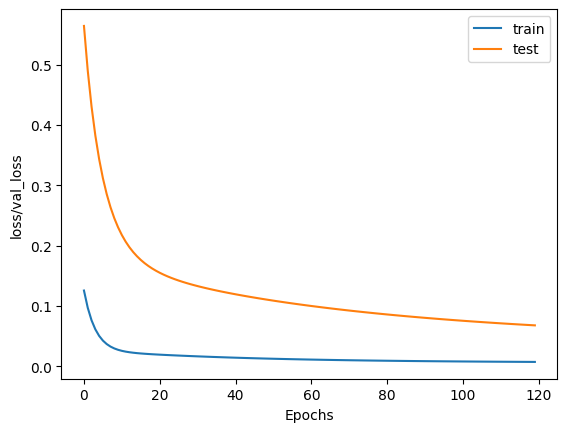

C:\Users\han\AppData\Local\Temp\ipykernel_9092\2116024318.py:49: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = GRUM(train_X,train_y,test_X,test_y)
C:\Users\han\AppData\Local\Temp\ipykernel_9092\2116024318.py:41: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = RandomForest(train_X,train_y,test_X,test_y)
C:\Users\han\AppData\Local\Temp\ipykernel_9092\2116024318.py:43: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new arr

Epoch 1/32
6/6 [==============================] - 0s 10ms/step - loss: 0.1309 - val_loss: 0.2887
Epoch 2/32
6/6 [==============================] - 0s 3ms/step - loss: 0.1204 - val_loss: 0.2690
Epoch 3/32
6/6 [==============================] - 0s 3ms/step - loss: 0.1107 - val_loss: 0.2502
Epoch 4/32
6/6 [==============================] - 0s 3ms/step - loss: 0.1016 - val_loss: 0.2325
Epoch 5/32
6/6 [==============================] - 0s 3ms/step - loss: 0.0933 - val_loss: 0.2158
Epoch 6/32
6/6 [==============================] - 0s 3ms/step - loss: 0.0857 - val_loss: 0.2004
Epoch 7/32
6/6 [==============================] - 0s 3ms/step - loss: 0.0787 - val_loss: 0.1861
Epoch 8/32
6/6 [==============================] - 0s 3ms/step - loss: 0.0725 - val_loss: 0.1729
Epoch 9/32
6/6 [==============================] - 0s 3ms/step - loss: 0.0669 - val_loss: 0.1607
Epoch 10/32
6/6 [==============================] - 0s 3ms/step - loss: 0.0619 - val_loss: 0.1496
Epoch 11/32
6/6 [=====================

C:\Users\han\AppData\Local\Temp\ipykernel_9092\2116024318.py:45: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = LR(train_X,train_y,test_X,test_y)
C:\Users\han\AppData\Local\Temp\ipykernel_9092\2116024318.py:47: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = SVRR(train_X,train_y,test_X,test_y)


23/23 [==============================] - 1s 8ms/step - loss: 0.1261 - val_loss: 0.1164
Epoch 2/120
23/23 [==============================] - 0s 2ms/step - loss: 0.1110 - val_loss: 0.1015
Epoch 3/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0979 - val_loss: 0.0887
Epoch 4/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0867 - val_loss: 0.0778
Epoch 5/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0771 - val_loss: 0.0686
Epoch 6/120
23/23 [==============================] - 0s 1ms/step - loss: 0.0689 - val_loss: 0.0607
Epoch 7/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0618 - val_loss: 0.0539
Epoch 8/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0558 - val_loss: 0.0482
Epoch 9/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0434
Epoch 10/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0392
Epoch 11/120
23/23 [=

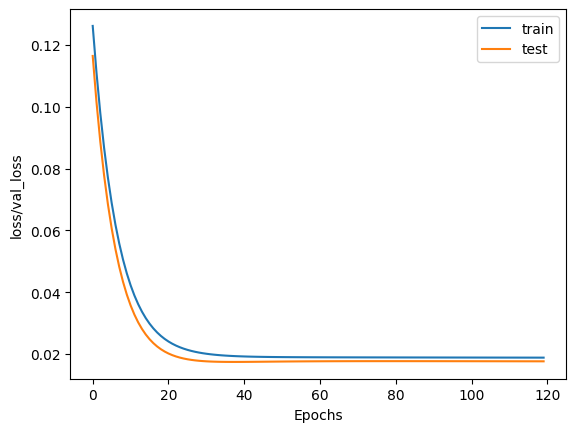

C:\Users\han\AppData\Local\Temp\ipykernel_9092\2116024318.py:49: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = GRUM(train_X,train_y,test_X,test_y)


Epoch 1/120
23/23 [==============================] - 1s 8ms/step - loss: 0.0851 - val_loss: 0.0716
Epoch 2/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0756 - val_loss: 0.0628
Epoch 3/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0674 - val_loss: 0.0553
Epoch 4/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0604 - val_loss: 0.0490
Epoch 5/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0437
Epoch 6/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0392
Epoch 7/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0355
Epoch 8/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0323
Epoch 9/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0297
Epoch 10/120
23/23 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0275
Epoch 11/

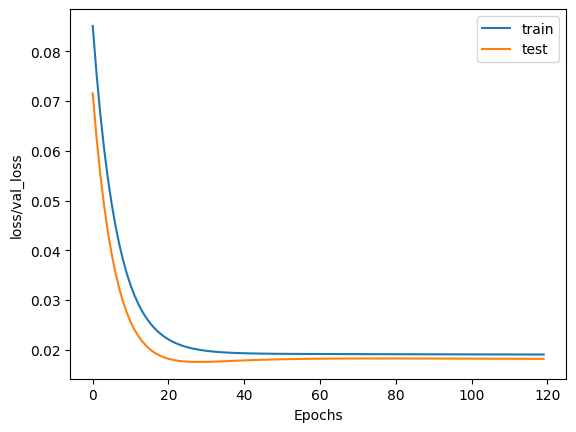

C:\Users\han\AppData\Local\Temp\ipykernel_9092\2116024318.py:49: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = GRUM(train_X,train_y,test_X,test_y)


In [3]:
if __name__ == '__main__':
    areas = ['DS4']
    indicator = ['EV','MAE','MSE','RMSE','R_square']

    # 如果是需要改动对比的算法，在这里进行改进即可
    classifers = ['RF','Adaboost','LinearRegression','SVR','GRU','studGA-RF','studGA-Adaboost','studGA-LinearRegression','studGA-SVR','studGA-GRU','studGA-OptimizedGRU']
    df = pd.DataFrame(columns=classifers, index=indicator)
    #df = pd.DataFrame()
    for area in areas:
        path = './{}/'.format(area)
        pre_data_df = pd.read_csv(path+'8area_{}.csv'.format(area))
        # 对每种方法进行遍历
        for method in classifers:
            data_df  =pre_data_df
            if method[:4]=='stud':
                res = pd.read_csv(path+'soea_studGA_templet/optPop/Chrom.csv',header=None)
                values = res.values
                features = data_df.columns[1:]
                best_features = []
                best_features.append('label_M')
                for index in range(values.shape[1]):
                     if values[0][index] == 1:#筛选出来的特征，如果是1则选上，如果是0，则不选。
                         best_features.append(features[index])
                data_df = data_df[best_features]
            values = data_df.values
            values = values.astype('float32')
            #进行标准化的操作
            scaler = MinMaxScaler(feature_range = (0,1))
            scaled = scaler.fit_transform(values)
            reframed = series_to_supervised(scaled,1,1)
            reframed.drop(reframed.columns[[i for i in range(int(reframed.shape[1] / 2) + 1, reframed.shape[1])]], axis=1,inplace=True)

            #split into input
            values = reframed.values
            n_train_hours = int(reframed.shape[0]*0.7)
            train = values[:n_train_hours:]
            test = values[n_train_hours:,:]
            train_X,train_y = train[:,:-1],train[:,-1]
            test_X ,test_y = test[:,:-1],test[:,-1]
            if re.search('RF', method):
                df.loc[:,method] = RandomForest(train_X,train_y,test_X,test_y)
            elif re.search('Adaboost',method):
                df.loc[:,method] = Adaboost(train_X,train_y,test_X,test_y)
            elif re.search('LinearRegression',method):
                df.loc[:,method] = LR(train_X,train_y,test_X,test_y)
            elif re.search('SVR', method):
                df.loc[:,method] = SVRR(train_X,train_y,test_X,test_y)
            elif re.search('GRU', method):
                df.loc[:,method] = GRUM(train_X,train_y,test_X,test_y)
        df.to_csv(path+'comparision_methods_{}.csv'.format(area))